IMPORT

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math
import datetime

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000


#path = '/Koding_With_Kolesh/challenges/RMB_NOWCAST_APRIL/'
cpi = pd.read_csv('CPI_Historic_Values_Zindi_Mar_23.csv')
vehicles = pd.read_csv('Naamsa_Vehicle_Sales.csv')

In [49]:
vehicles

,Month,Local_Passenger_Vehicles,Export_Sales_Passenger_Vehicles,Local_Light_Commercial_Vehicles,Export_Sales_Light_Commercial_Vehicles,Local_Medium_Commercial_Vehicles,Export_Sales_Medium_Commercial_Vehicles,Local_Heavy_Commercial_Vehicles,Export_Sales_Heavy_Commercial_Vehicles,Local_Extra_Heavy_Commercial_Vehicles,Export_Sales_Extra_Heavy_Commercial_Vehicles,Local_Bus_Sales,Export_Sales_Buses,Total_Local Sales,Total_Export_Sales,Date,year_month
0,23-Mar,31631,23481,15529,10578,870,18,491,32,1593,25,43,0,50157,34134,2023-03-31,2023-03
1,23-Feb,29976,20079,12972,10244,697,33,435,8,1244,40,28,5,45352,30409,2023-02-28,2023-02
2,23-Jan,31072,11227,10622,9243,461,5,331,28,976,29,47,4,43509,20536,2023-01-31,2023-01
3,22-Dec,28793,16844,10438,9406,865,15,417,11,1198,26,72,0,41783,26302,2022-12-31,2022-12
4,22-Nov,32859,23522,13477,10710,900,32,546,13,1551,33,80,0,49413,34310,2022-11-30,2022-11
5,22-Oct,30597,18023,12738,11373,769,43,523,35,1285,32,54,2,45966,29508,2022-10-31,2022-10
6,22-Sep,32392,23680,12573,17691,882,17,490,56,1367,27,82,3,47786,41474,2022-09-30,2022-09
7,22-Aug,31269,17622,13281,10981,715,10,558,25,1516,21,81,3,47420,28662,2022-08-31,2022-08
8,22-Jul,31455,23479,9547,7670,790,21,471,50,1281,18,49,4,43593,31242,2022-07-31,2022-07
9,22-Jun,29545,23745,8877,9194,697,57,560,33,1263,10,77,15,41019,33054,2022-06-30,2022-06


In [38]:
cpi_pivot = cpi.pivot(index = 'Month', columns = 'Category', values = 'Value').reset_index()#changing from a long format to a wide format,
cpi_pivot['Month'] = pd.to_datetime(cpi_pivot['Month'])
cpi_pivot = cpi_pivot.sort_values("Month").reset_index(drop=True)
cpi_pivot

Category,Month,Alcoholic beverages and tobacco,Clothing and footwear,Communication,Education,Food and non-alcoholic beverages,Headline_CPI,Health,Household contents and services,Housing and utilities,Miscellaneous goods and services,Recreation and culture,Restaurants and hotels,Transport
0,2022-01-31,100.0,100.2,99.8,100.0,100.9,100.2,100.1,100.4,100.0,100.6,100.2,101.2,98.9
1,2022-02-28,100.6,100.3,99.7,100.0,101.8,100.8,103.2,100.4,100.1,101.5,100.3,101.9,100.6
2,2022-03-31,102.8,100.5,99.7,104.4,102.4,101.8,103.7,100.8,100.5,101.9,100.4,103.0,103.7
3,2022-04-30,103.6,100.7,99.6,104.4,103.1,102.4,104.0,101.1,100.5,102.8,100.7,103.3,105.1
4,2022-05-31,104.4,100.9,99.9,104.4,105.3,103.1,104.3,101.8,100.6,102.9,101.0,103.8,105.9
5,2022-06-30,104.5,101.3,100.3,104.4,106.6,104.2,104.6,103.0,101.2,103.0,101.2,104.2,110.3
6,2022-07-31,104.4,101.6,99.4,104.4,107.8,105.8,104.1,103.3,103.1,103.4,102.3,104.6,115.6
7,2022-08-31,104.7,102.1,100.1,104.4,109.7,106.0,104.2,103.7,103.2,103.5,102.4,104.3,114.5
8,2022-09-30,105.6,102.5,99.9,104.4,110.3,106.1,104.0,104.5,103.7,103.8,102.5,106.2,112.0
9,2022-10-31,106.1,102.6,99.8,104.4,111.3,106.5,104.5,105.0,103.8,104.7,102.7,107.4,111.7


EDA

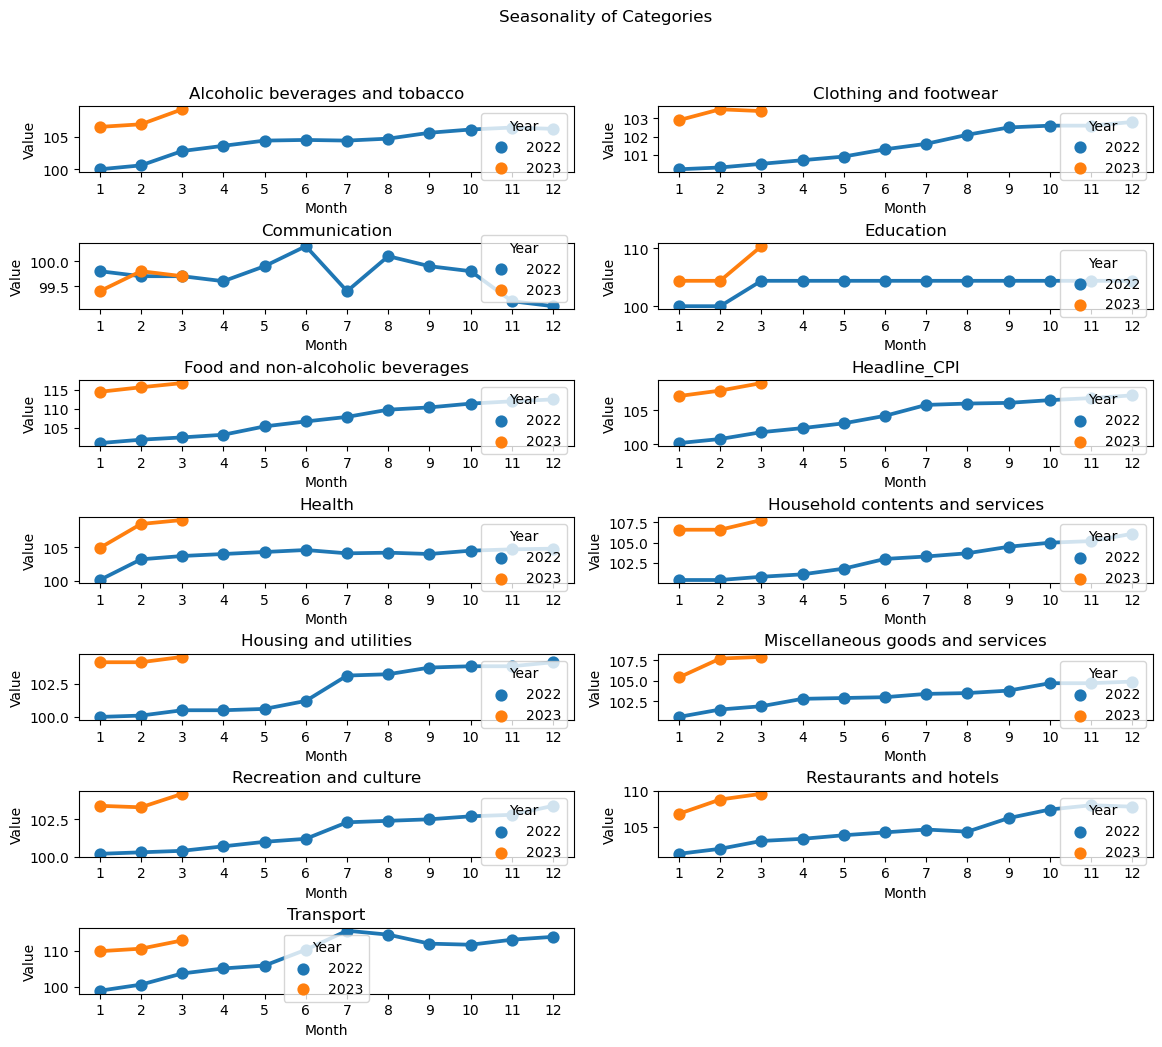

In [39]:
# Create a temporary dataframe with Month and Year columns
df_temp = cpi_pivot.copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp['Month']).year
df_temp['Month'] = pd.DatetimeIndex(df_temp['Month']).month

# Define the categories to plot
categories_to_plot = cpi_pivot.columns[1:]

# Create subplots
num_categories = len(categories_to_plot)
num_rows = math.ceil(num_categories / 2)
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 10))
fig.tight_layout(pad=3.0)

# Iterate over each category and plot its seasonality
for i, category in enumerate(categories_to_plot):
    row = i // num_cols
    col = i % num_cols

    ax = axs[row, col] if num_rows > 1 else axs[col]

    sns.pointplot(x='Month', y=category, hue='Year', data=df_temp, ax=ax)
    ax.set_title(category)
    ax.set_xlabel('Month')
    ax.set_ylabel('Value')

# Hide any unused subplots
for i in range(num_categories, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols

    ax = axs[row, col] if num_rows > 1 else axs[col]
    ax.axis('off')

plt.suptitle('Seasonality of Categories', y=1.05)
plt.show()

ADD THE APRIL ROW

In [40]:
date_str = '2023-04-30'
date_obj = pd.to_datetime(date_str)
new_row = pd.DataFrame({'Month': [date_obj]})
cpi_pivot = pd.concat([cpi_pivot, new_row]).reset_index(drop=True)

Additional Data

* Vehicles

In [41]:
cpi_pivot['year_month'] = pd.to_datetime(cpi_pivot['Month'], format='%Y-%b').dt.strftime('%Y-%m')
start_date = datetime.datetime.strptime("2020-12-31", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2023-03-31", "%Y-%m-%d")

# difference between each date. M means one month end
D = 'M'

date_list = pd.date_range(start_date, end_date, freq=D)[::-1]
vehicles['Date'] = date_list
vehicles['Date'] = pd.to_datetime(vehicles['Date'], format='%Y-%b-%d')
vehicles['year_month'] = pd.to_datetime(vehicles['Date'], format='%Y-%b').dt.strftime('%Y-%m')

cpi_pivot = cpi_pivot.merge(vehicles[['year_month', 'Total_Local Sales', 'Total_Export_Sales']], on='year_month', how='left')

FEATURE ENGINNERING

In [42]:
feats_to_lag = [col for col in cpi_pivot.columns if col not in ['Month', 'year_month']]
for col in feats_to_lag:
  for i in range(1, 8):
    cpi_pivot[f"prev_{i}_month_{col}"]= cpi_pivot[col].shift(i)

HANDLE MISSING DATA

In [43]:
cpi_pivot = cpi_pivot.drop(0)
cpi_pivot = cpi_pivot.bfill()

TRAIN AND VALIDATION

In [44]:
train = cpi_pivot[cpi_pivot['Month'] != "2023-04-30"]
test = cpi_pivot[cpi_pivot['Month'] == "2023-04-30"]

training_set = train[train['Month']!= '2023-03-31']
validation_set = train[train['Month']== '2023-03-31']

train.shape, test.shape, training_set.shape, validation_set.shape

((14, 122), (1, 122), (13, 122), (1, 122))

MODELING

In [45]:
target_cols = ['Alcoholic beverages and tobacco', 'Clothing and footwear',
       'Communication', 'Education', 'Food and non-alcoholic beverages',
       'Headline_CPI', 'Health', 'Household contents and services',
       'Housing and utilities', 'Miscellaneous goods and services',
       'Recreation and culture', 'Restaurants and hotels ', 'Transport']

#if you add additional data sources that have no value in the predicting month , drop it, now that you have their lags
features= [col for col in train.columns if col not in target_cols + ['Month', 'year_month','Total_Local Sales', 'Total_Export_Sales']]


X_train = training_set[features]
y_train = training_set[target_cols]

X_val = validation_set[features]
y_val = validation_set[target_cols]

x_models = {}
lr_models = {}
y_pred = []
y_predx = []
scaler = MinMaxScaler()

#training
for target_col in target_cols:
    lr_model = LinearRegression()
    x_model = XGBRegressor()
    X_train_scaled = scaler.fit_transform(X_train)
    lr_model.fit(X_train_scaled, y_train[target_col])
    x_model.fit(X_train, y_train[target_col])
    lr_models[target_col] = lr_model
    x_models[target_col] = x_model
#validation
for target_col in target_cols:
    lr_model = lr_models[target_col]
    x_model = x_models[target_col]
    X_val_scaled = scaler.transform(X_val)
    y_pred_col = lr_model.predict(X_val_scaled)
    y_pred_colx = x_model.predict(X_val)
    y_pred.append(y_pred_col)
    y_predx.append(y_pred_colx)


#scoring

y_pred = np.array(y_pred).T
y_predx = np.array(y_predx).T
df = pd.DataFrame({'y_pred': y_pred.flatten(), 'y_val': y_val.values.flatten()})
dfx = pd.DataFrame({'y_pred': y_predx.flatten(), 'y_val': y_val.values.flatten()})
#calculate the rmse
rmse = np.sqrt(mean_squared_error(df['y_pred'], df['y_val']))
rmsex = np.sqrt(mean_squared_error(dfx['y_pred'], df['y_val']))
print(f'RMSE of Liner Regression: {rmse}') 
print(f'RMSE of XGB: {rmsex}') 

RMSE of Liner Regression: 0.7170057743628517
RMSE of XGB: 2.0561384622612566


In [46]:
X_train = train[features]
y_train = train[target_cols]

X_val = test[features]
y_val = test[target_cols]

x_models = {}
lr_models = {}
y_pred = []
y_predx = []
scaler = MinMaxScaler()

#training
for target_col in target_cols:
    lr_model = LinearRegression()
    x_model = XGBRegressor(max_depth=4, n_estimators=350, learning_rate=0.17, alpha=0, objective='reg:squarederror')
    X_train_scaled = scaler.fit_transform(X_train)
    lr_model.fit(X_train_scaled, y_train[target_col])
    x_model.fit(X_train, y_train[target_col])
    lr_models[target_col] = lr_model
    x_models[target_col] = x_model
#pridiction
for target_col in target_cols:
    lr_model = lr_models[target_col]
    x_model = x_models[target_col]
    X_val_scaled = scaler.transform(X_val)
    y_pred_col = lr_model.predict(X_val_scaled)
    y_pred_colx = x_model.predict(X_val)
    y_pred.append(y_pred_col)
    y_predx.append(y_pred_colx)

y_pred = np.array(y_pred).T
y_predx = np.array(y_predx).T
print(f'pridiction of Liner Regression: {y_pred}') 
print(f'prediction of XGB: {y_predx}') 

pridiction of Liner Regression: [[110.1288306  103.84118398  99.68113182 109.95597569 118.02566582
  109.73966395 109.95584293 108.13333177 104.55771629 109.40084772
  104.4878531  110.31967149 113.67698738]]
prediction of XGB: [[109.19828  103.49865   99.4117   110.3987   116.698715 108.99868
  109.09866  107.79872  104.49845  107.89874  104.19868  108.59806
  113.24185 ]]


SUBMITION

In [47]:
def prepSub(y_pred:list, target_cols: list, test, prefix:str):
    sub_df = pd.DataFrame(y_pred, columns=target_cols)
    sub_df['Month'] = test['Month']
    
    sub_df.set_index('Month', inplace=True)
    sub_df.columns = [prefix+'_' + col.lower().replace('_', ' ').strip() for col in sub_df.columns]
    sub_df.rename(columns= {f"{prefix}_headline cpi": f"{prefix}_headline CPI"}, inplace=True)
    
    sub_df = pd.melt(sub_df.reset_index(), id_vars= ['Month'], var_name= 'ID', value_name= 'Value')
    
    return sub_df[['ID', 'Value']]

In [48]:
sub = prepSub(y_pred, target_cols, test, 'April') 
sub.to_csv('out/sub5.csv', index=False)